Run on NERSC

In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
from astropy.io import fits
import healpy as hp
from astropy import wcs

import match_coord

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
def plot_cutout(img, pixscale, decraoff=None, vmin=-1, vmax=1, unit='arcsec', axis_label=None, colorbar=False, cbar_label=None, title=None, axis=None, figsize=(8, 8)):
    '''
    decraoff: [dec_offset, ra_offset]
    '''
    if unit=='arcsec':
        rescale = 1.
    elif unit=='arcmin':
        rescale = 60.
    elif unit=='deg':
        rescale = 3600.
    else:
        raise ValueError('unrecognized unit')
    extent = 0.5*pixscale*(img.shape[1]*np.array([-1, 1, 0, 0])+img.shape[0]*np.array([0, 0, -1, 1]))/rescale

    if decraoff is not None:
        dec_offset, ra_offset = decraoff
        extent[0] -= dec_offset # DEC
        extent[1] -= dec_offset # DEC
        extent[2] += ra_offset # RA
        extent[3] += ra_offset # RA
    
    fig, ax = plt.subplots(figsize=figsize)
    dens = ax.imshow(img, aspect='equal',
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    ax.axvline(0, ls='--', lw=0.5, color='grey')
    ax.axhline(0, ls='--', lw=0.5, color='grey')
    if colorbar:
        cbar = fig.colorbar(dens, fraction=0.046, pad=0.04)
    if cbar_label is not None:
        cbar.ax.set_ylabel(cbar_label)
    ax.grid(alpha=0.5)
    if axis_label is not None:
        ax.set_xlabel(axis_label[0])
        ax.set_ylabel(axis_label[1])
    if title is not None:
        ax.set_title(title)
    if axis is not None:
        ax.axis(axis)
    return ax

def plot_cutout_sidebyside(img1, img2, pixscale, decraoff=None, vmin=-1, vmax=1, unit='arcsec', axis_label=None, axis=None, title1=None, title2=None, figsize=(20, 10), crosshair=True, grid=False):
    '''
    decraoff: [dec_offset, ra_offset]
    '''
    if unit=='arcsec':
        rescale = 1.
    elif unit=='arcmin':
        rescale = 60.
    elif unit=='deg':
        rescale = 3600.
    else:
        raise ValueError('unrecognized unit')
    extent = 0.5*pixscale*(img1.shape[1]*np.array([-1, 1, 0, 0])+img1.shape[0]*np.array([0, 0, -1, 1]))/rescale

    if decraoff is not None:
        dec_offset, ra_offset = decraoff
        extent[0] -= dec_offset # DEC
        extent[1] -= dec_offset # DEC
        extent[2] += ra_offset # RA
        extent[3] += ra_offset # RA
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    axes[0].imshow(img1, aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    if crosshair:
        axes[0].axvline(0, ls='--', lw=0.5, color='grey')
        axes[0].axhline(0, ls='--', lw=0.5, color='grey')
    if title1 is not None:
        axes[0].set_title(title1)
    im = axes[1].imshow(img2, aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    axes[1].axvline(0, ls='--', lw=0.5, color='grey')
    axes[1].axhline(0, ls='--', lw=0.5, color='grey')
    if title2 is not None:
        axes[1].set_title(title2)
    if axis_label is not None:
        axes[0].set_xlabel(axis_label[0])
        axes[0].set_ylabel(axis_label[1])
        axes[1].set_xlabel(axis_label[0])
        axes[1].set_ylabel(axis_label[1])
    # fig.colorbar(im, fraction=0.046, pad=0.04)
    if grid:
        axes[0].grid(alpha=0.5)
        axes[1].grid(alpha=0.5)
    if axis is not None:
        axes[0].axis(axis)
        axes[1].axis(axis)
    return axes

def binned_std(x, y, bins):
    bin_center, bin_std = np.zeros((2, len(bins)-1))
    for index in range(len(bins)-1):
        mask = (x>bins[index]) & (x<bins[index+1])
        bin_center[index] = np.mean(x[mask])
        if np.sum(mask)>0:
            bin_std[index] = np.std(y[mask])
        else:
            bin_std[index] = np.nan
    return bin_center, bin_std

def binned_mean(x, y, bins):
    bin_center, bin_mean = np.zeros((2, len(bins)-1))
    for index in range(len(bins)-1):
        mask = (x>bins[index]) & (x<bins[index+1])
        bin_center[index] = np.mean(x[mask])
        if np.sum(mask)>0:
            bin_mean[index] = np.mean(y[mask])
        else:
            bin_mean[index] = np.nan
    return bin_center, bin_mean

In [4]:
from scipy.optimize import curve_fit

def get_frac_moffat(r, alpha, beta):
    """
    Calculate the fraction of light within radius r of a Moffat profile.
    """    
    frac = 1 - alpha**(2*(beta-1))*(alpha**2 + r**2)**(1-beta)
    return(frac)

def get_sb_moffat(r, alpha, beta):
    """
    Calculate the surface brightness of light at radius r of a Moffat profile.
    The integral (i.e., total flux) is unity by definition.
    """
    i = (beta-1)/(np.pi * alpha**2)*(1 + (r/alpha)**2)**(-beta)
    return i

def get_sb_moffat_plus_power_law(r, alpha1, beta1, plexp2, weight2):
    """
    Calculate the surface brightness of light at radius r of the sum of two Moffat profiles.
    The integral (i.e., total flux) is NOT unity.
    """
    i = (beta1-1)/(np.pi * alpha1**2)*(1 + (r/alpha1)**2)**(-beta1) \
        + weight2 *r**(plexp2)
    return i

def get_sb_double_moffat(r, alpha1, beta1, alpha2, beta2, weight2):
    """
    Calculate the surface brightness of light at radius r of the sum of two Moffat profiles.
    The integral (i.e., total flux) is NOT unity.
    """
    i = (beta1-1)/(np.pi * alpha1**2)*(1 + (r/alpha1)**2)**(-beta1) \
        + weight2 * (beta2-1)/(np.pi * alpha2**2)*(1 + (r/alpha2)**2)**(-beta2)
    return i

In [5]:
params = {
'g_weight2': 0.00045, 'g_plexp2': -2.,
'r_weight2': 0.00033, 'r_plexp2': -2.,
'z_alpha2': 17.650, 'z_beta2': 1.7, 'z_weight2': 0.0145,
}

outlier_ccd_list = ['N20', 'S8', 'S10', 'S18', 'S21', 'S27']
params_outlier = {'z_alpha2': 16, 'z_beta2': 2.3, 'z_weight2': 0.0095}

field = 'south'
region_name = 'decals_ngc'
pixscale = 0.262

0.451153205656
0.825985645545


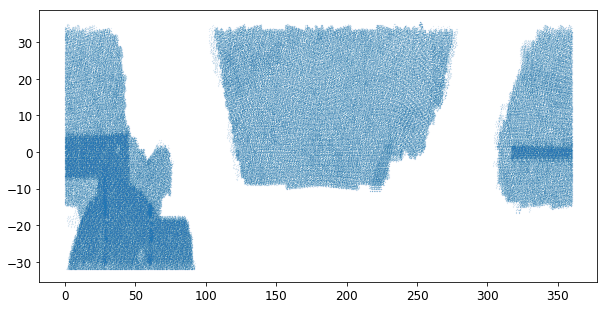

In [6]:
ccd_columns = ['image_filename', 'image_hdu', 'camera', 'expnum', 'ccdname', 'filter', 'fwhm', 'ra', 'dec', 'ccd_cuts', 'ccdzpt', 'exptime', 'ccdraoff', 'ccddecoff', 'propid']
surveyccd_path = '/global/project/projectdirs/cosmo/work/legacysurvey/dr9/reorg/decam/survey-ccds-decam-dr8-newlocs2.fits.gz'

ccd = fitsio.read(surveyccd_path, columns=ccd_columns)
ccd = Table(ccd)

mask = ccd['ccd_cuts']==0
print(np.sum(mask)/len(mask))
ccd = ccd[mask]

mask = ccd['dec']>-32
print(np.sum(mask)/len(mask))
ccd = ccd[mask]

plt.figure(figsize=(10, 5))
plt.plot(ccd['ra'][::10], ccd['dec'][::10], '.', ms=0.1)
plt.show()

In [7]:
t = Table()
t['propid'], t['counts'] = np.unique(ccd['propid'], return_counts=True)
t['frac (%)'] = t['counts']/len(ccd)*100
t['frac (%)'].format = '%.1f'
t.sort('counts')
t

propid,counts,frac (%)
bytes10,int64,float64
2017A-0260,3477,0.1
2015A-0620,11760,0.4
2016A-0190,31666,1.0
2012B-0001,1025869,31.7
2014B-0404,2160059,66.8


In [8]:
mask = (ccd['propid']=='2014B-0404') & (ccd['filter']==band)
plt.hist(ccd['exptime'][mask], 100, normed=False, alpha=0.5, range=(0, 300), label='DECaLS')
mask = (ccd['propid']=='2012B-0001') & (ccd['filter']==band)
plt.hist(ccd['exptime'][mask], 100, normed=False, alpha=0.5, range=(0, 300), label='DES')
plt.xlabel('exptime')
plt.legend()
plt.show()

NameError: name 'band' is not defined

## Moffat fit of the PSFEx model

In [ ]:
band = 'g'
np.random.seed(3)
ccd_index = np.random.choice(len(ccd))

In [ ]:
expnum_str = str(ccd['expnum'][ccd_index])
ccdname = ccd['ccdname'][ccd_index]
fn_prefix = ccd['camera'][ccd_index]+'-'+(5-len(expnum_str[:3]))*'0'+expnum_str+'-'+ccdname
print(ccd['propid'][ccd_index], ccd['exptime'][ccd_index])
# print(fn_prefix)
# print('seeing = {:.2f} arcsec'.format(ccd['seeing'][ccd_index]))
# print('airmass = {:.2f}'.format(ccd['airmass'][ccd_index]))

########## Outer PSF parameters ###########
if band=='z' and (ccdname in outlier_ccd_list):
    params_to_use = params_outlier
else:
    params_to_use = params
    
if band!='z':
    plexp2, weight2 = params_to_use[band+'_plexp2'], params_to_use[band+'_weight2']
else:
    alpha2, beta2, weight2 = params_to_use[band+'_alpha2'], params_to_use[band+'_beta2'],  params_to_use[band+'_weight2']

################# PSFEx #################
psfex_dir = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/calib/decam/psfex-merged'
psfex_fn = os.path.join(psfex_dir, '{}/decam-{}.fits'.format((5-len(expnum_str[:3]))*'0'+expnum_str[:3], (8-len(expnum_str))*'0'+expnum_str))
hdu = fits.open(psfex_fn)
data = hdu[1].data
psfex_index = np.where(data['ccdname']==ccdname)[0][0]

psf0 = data['psf_mask'][psfex_index, 0]
# normalize to a 22.5 magnitude star
psf0 = psf0/np.sum(psf0)

# vrange = 0.0002
# ax = plot_cutout(psf0, pixscale, vmin=-vrange, vmax=vrange, axis_label=['DEC direction (arcsec)', 'RA direction (arcsec)'])
# plt.show()

grid = pixscale * np.linspace(-0.5*(psf0.shape[0]-1), 0.5*(psf0.shape[0]-1), psf0.shape[0])
xx, yy = np.meshgrid(grid, grid)
radius_grid = np.sqrt(xx**2 + yy**2)
radius = radius_grid.flatten()

################# Moffat fit ##############

radius_min, radius_max = 1.5, 5.0

psf0_flat = psf0.flatten()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # popt, pcov =  curve_fit(get_sb_moffat, radius, psf0_flat/(pixscale**2))
    mask = (radius>radius_min) & (radius<radius_max)
    popt, pcov = curve_fit(get_sb_moffat, radius[mask], psf0_flat[mask]/(pixscale**2), bounds=((0, 1.8), np.inf))

alpha, beta = popt
print('alpha, beta = {:.3f}, {:.3f}'.format(alpha, beta))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    radius_plot = np.linspace(0, 30, 500)
    if band!='z':
        psf_predict = pixscale**2 * get_sb_moffat_plus_power_law(radius_grid, alpha, beta, plexp2, weight2)
        psf_plot = pixscale**2 * get_sb_moffat_plus_power_law(radius_plot, alpha, beta, plexp2, weight2)
        psf_plot1 = pixscale**2 * get_sb_moffat(radius_plot, alpha, beta)
        psf_plot2 = weight2 * pixscale**2 * radius_plot**(plexp2)
    else:
        psf_predict = pixscale**2 * get_sb_double_moffat(radius_grid, alpha, beta, alpha2, beta2, weight2)
        psf_plot = pixscale**2 * get_sb_double_moffat(radius_plot, alpha, beta, alpha2, beta2, weight2)
        psf_plot1 = pixscale**2 * get_sb_moffat(radius_plot, alpha, beta)
        psf_plot2 = weight2 * pixscale**2 * get_sb_moffat(radius_plot, alpha2, beta2)

    plt.figure(figsize=(8, 6))
    plt.loglog(radius, psf0_flat, '.', ms=1., label='PSFEx model')
    plt.loglog(radius_plot, psf_plot, '-', lw=1, label='inner PSF + outer PSF')
    plt.loglog(radius_plot, psf_plot1, '--', lw=1.2, alpha=1., label='inner PSF')
    plt.loglog(radius_plot, psf_plot2, ':', lw=1.2, alpha=1., label='outer PSF')
    mask = radius_plot>0.5
    # plt.loglog(radius_plot[mask], 10**(profile_fit(np.log10(radius_plot)))[mask], 'C2--', lw=1.2, label='polynomial')
    plt.axis([0.2, 10, 3e-7, 0.05])
    plt.grid(alpha=0.5)
    plt.xlabel('radius (arcsec)')
    plt.ylabel('normalized SB (nmgy/pixel)')
    plt.title('{}-{}  alpha={:.3f}  beta={:.3f}'.format(expnum_str, ccdname, alpha, beta))
    plt.legend(markerscale=3)
    plt.show()
        
    bins = np.arange(1, 8, 0.2)
    bin_center, bin_mean = binned_mean(radius, 1000*(psf0_flat-psf_predict.flatten()), bins=bins)
    bin_center, bin_std = binned_std(radius, 1000*(psf0_flat-psf_predict.flatten()), bins=bins)

    plt.figure(figsize=(8, 6))
    plt.plot(radius, 1000*(psf0_flat-psf_predict.flatten()), '.', ms=1., label='PSFEx model')
    plt.plot(bin_center, 10*bin_mean, '-')
    plt.plot(bin_center, 0.05*bin_std/np.mean(bin_std[-15:-5]), '-')
    plt.axhline(0, color='k', lw=0.5)
    # plt.axis([0.5, 6, -1, 1])
    plt.axis([0.5, 8, -1e-1, 1e-1])
    plt.grid(alpha=0.5)
    plt.xlabel('radius (arcsec)')
    plt.ylabel('1000 * residual (nmgy/pixel)')
    plt.title('{}-{}  alpha={:.3f}  beta={:.3f}'.format(expnum_str, ccdname, alpha, beta))
    plt.legend(markerscale=3)
    plt.show()

2012B-0001 90.0
alpha, beta = 1.070, 2.671
0.105% difference in total flux


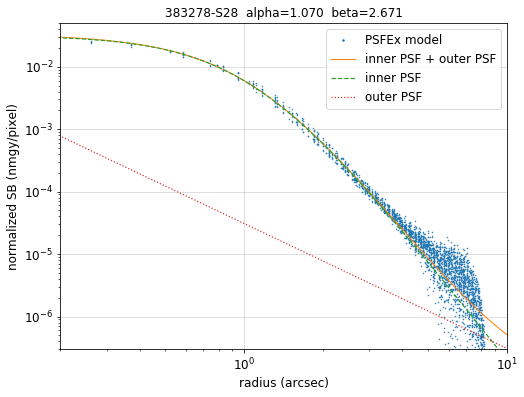

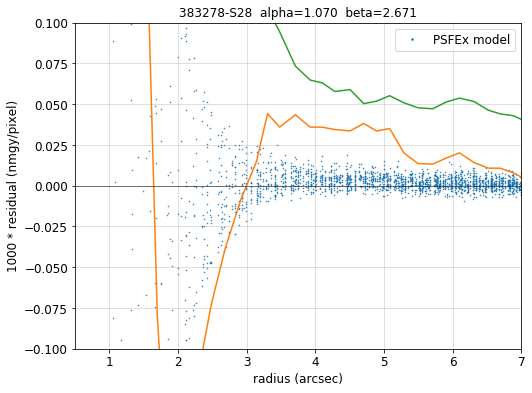

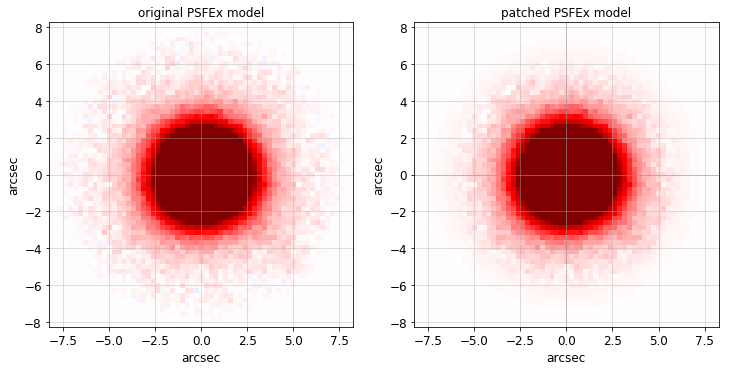

In [172]:
band = 'g'
np.random.seed(1)
ccd_index_list = np.random.choice(len(ccd), size=len(ccd), replace=False)

# for index in range(20):
for index in [7]:
    
    ccd_index = ccd_index_list[index]

    expnum_str = str(ccd['expnum'][ccd_index])
    ccdname = ccd['ccdname'][ccd_index]
    fn_prefix = ccd['camera'][ccd_index]+'-'+(5-len(expnum_str[:3]))*'0'+expnum_str+'-'+ccdname
    print(ccd['propid'][ccd_index], ccd['exptime'][ccd_index])
    # print(fn_prefix)
    # print('seeing = {:.2f} arcsec'.format(ccd['seeing'][ccd_index]))
    # print('airmass = {:.2f}'.format(ccd['airmass'][ccd_index]))

    ########## Outer PSF parameters ###########
    if band=='z' and (ccdname in outlier_ccd_list):
        params_to_use = params_outlier
    else:
        params_to_use = params

    if band!='z':
        plexp2, weight2 = params_to_use[band+'_plexp2'], params_to_use[band+'_weight2']
    else:
        alpha2, beta2, weight2 = params_to_use[band+'_alpha2'], params_to_use[band+'_beta2'],  params_to_use[band+'_weight2']

    ################# PSFEx #################
    psfex_dir = '/global/project/projectdirs/cosmo/data/legacysurvey/dr8/calib/decam/psfex-merged'
    psfex_fn = os.path.join(psfex_dir, '{}/decam-{}.fits'.format((5-len(expnum_str[:3]))*'0'+expnum_str[:3], (8-len(expnum_str))*'0'+expnum_str))
    hdu = fits.open(psfex_fn)
    data = hdu[1].data
    psfex_index = np.where(data['ccdname']==ccdname)[0][0]

    psf0 = data['psf_mask'][psfex_index, 0]
    # normalize to a 22.5 magnitude star
    psf0 = psf0/np.sum(psf0)

    # vrange = 0.0002
    # ax = plot_cutout(psf0, pixscale, vmin=-vrange, vmax=vrange, axis_label=['DEC direction (arcsec)', 'RA direction (arcsec)'])
    # plt.show()

    grid = pixscale * np.linspace(-0.5*(psf0.shape[0]-1), 0.5*(psf0.shape[0]-1), psf0.shape[0])
    xx, yy = np.meshgrid(grid, grid)
    radius_grid = np.sqrt(xx**2 + yy**2)
    radius = radius_grid.flatten()

    ################# Moffat fit ##############

    radius_min, radius_max = 1.5, 5.0

    psf0_flat = psf0.flatten()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # popt, pcov =  curve_fit(get_sb_moffat, radius, psf0_flat/(pixscale**2))
        mask = (radius>radius_min) & (radius<radius_max)
        popt, pcov = curve_fit(get_sb_moffat, radius[mask], psf0_flat[mask]/(pixscale**2), bounds=((0, 1.8), np.inf))

    alpha, beta = popt
    print('alpha, beta = {:.3f}, {:.3f}'.format(alpha, beta))

    
    psf_vrange = 0.00015

    # radius_lim1, radius_lim2 = 5., 6.
    radius_lim1, radius_lim2 = 5.5, 6.5
    radius_lim3, radius_lim4 = 7., 8.

    psf0_hybrid = psf0.copy()

    r1, r2 = radius_lim1, radius_lim2
    mask = (radius_grid>r1) & (radius_grid<r2)
    psf0_hybrid[mask] = psf0[mask] * (r2-radius_grid[mask])/(r2-r1) \
                   + psf_predict[mask] * (radius_grid[mask]-r1)/(r2-r1)

    r1, r2 = radius_lim2, radius_lim3
    mask = (radius_grid>=r1) & (radius_grid<r2)
    psf0_hybrid[mask] = psf_predict[mask]

    r1, r2 = radius_lim3, radius_lim4
    mask = (radius_grid>=r1) & (radius_grid<r2)
    psf0_hybrid[mask] = psf_predict[mask] * (r2-radius_grid[mask])/(r2-r1) \
                   + 0 * (radius_grid[mask]-r1)/(r2-r1)

    mask = (radius_grid>radius_lim4)
    psf0_hybrid[mask] = 0

    print('{:.3f}% difference in total flux'.format(100*(1-np.sum(psf0_hybrid)/np.sum(psf0))))

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        radius_plot = np.linspace(0, 30, 500)
        if band!='z':
            psf_predict = pixscale**2 * get_sb_moffat_plus_power_law(radius_grid, alpha, beta, plexp2, weight2)
            psf_plot = pixscale**2 * get_sb_moffat_plus_power_law(radius_plot, alpha, beta, plexp2, weight2)
            psf_plot1 = pixscale**2 * get_sb_moffat(radius_plot, alpha, beta)
            psf_plot2 = weight2 * pixscale**2 * radius_plot**(plexp2)
        else:
            psf_predict = pixscale**2 * get_sb_double_moffat(radius_grid, alpha, beta, alpha2, beta2, weight2)
            psf_plot = pixscale**2 * get_sb_double_moffat(radius_plot, alpha, beta, alpha2, beta2, weight2)
            psf_plot1 = pixscale**2 * get_sb_moffat(radius_plot, alpha, beta)
            psf_plot2 = weight2 * pixscale**2 * get_sb_moffat(radius_plot, alpha2, beta2)

        plt.figure(figsize=(8, 6))
        plt.loglog(radius, psf0_flat, '.', ms=1., label='PSFEx model')
        plt.loglog(radius_plot, psf_plot, '-', lw=1, label='inner PSF + outer PSF')
        plt.loglog(radius_plot, psf_plot1, '--', lw=1.2, alpha=1., label='inner PSF')
        plt.loglog(radius_plot, psf_plot2, ':', lw=1.2, alpha=1., label='outer PSF')
        mask = radius_plot>0.5
        # plt.loglog(radius_plot[mask], 10**(profile_fit(np.log10(radius_plot)))[mask], 'C2--', lw=1.2, label='polynomial')
        plt.axis([0.2, 10, 3e-7, 0.05])
        plt.grid(alpha=0.5)
        plt.xlabel('radius (arcsec)')
        plt.ylabel('normalized SB (nmgy/pixel)')
        plt.title('{}-{}  alpha={:.3f}  beta={:.3f}'.format(expnum_str, ccdname, alpha, beta))
        plt.legend(markerscale=3)
        plt.show()

        bins = np.arange(1, 8, 0.2)
        bin_center, bin_mean = binned_mean(radius, 1000*(psf0_flat-psf_predict.flatten()), bins=bins)
        bin_center, bin_std = binned_std(radius, 1000*(psf0_flat-psf_predict.flatten()), bins=bins)

        plt.figure(figsize=(8, 6))
        plt.plot(radius, 1000*(psf0_flat-psf_predict.flatten()), '.', ms=1., label='PSFEx model')
        plt.plot(bin_center, 10*bin_mean, '-')
        plt.plot(bin_center, 0.05*bin_std/np.mean(bin_std[-15:-5]), '-')
        plt.axhline(0, color='k', lw=0.5)
        # plt.axis([0.5, 6, -1, 1])
        plt.axis([0.5, 7, -1e-1, 1e-1])
        plt.grid(alpha=0.5)
        plt.xlabel('radius (arcsec)')
        plt.ylabel('1000 * residual (nmgy/pixel)')
        plt.title('{}-{}  alpha={:.3f}  beta={:.3f}'.format(expnum_str, ccdname, alpha, beta))
        plt.legend(markerscale=3)
        plt.show()
        
        plot_cutout_sidebyside(psf0, psf0_hybrid, pixscale, vmin=-psf_vrange, vmax=psf_vrange, figsize=(12, 6), title1='original PSFEx model', title2='patched PSFEx model', crosshair=False, grid=True, axis_label=['arcsec', 'arcsec'])
        plt.show()

__Fit the original PSFEx model with the patched model__

In [126]:
from scipy.optimize import minimize_scalar
# least-square fit
func = lambda a: np.sum((a * psf0_hybrid - psf0)**2)
a = minimize_scalar(func).x
print(a)

1.00000033779
